### Ensemble means using different predictors to classify a prediction

this works because we have the law of large numbers

they work best if they are indepnendent (each using different algorithms)

In [2]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=452))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=452))])

VotingClassifier clones every estimator and fits the clones, the original estimators are available via estimators_ attribute

In [3]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


2 out of 3 predict via hard voting so we get a class 1:

In [8]:
voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [10]:
voting_clf.score(X_test, y_test)

0.912

Soft voting predicts the class with highest class probability averaged over all individual classifiers

In [12]:
# SVC needs special treatment it needs to use cross-validation so setting the probability feature to True
voting_clf.voting = "soft"
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

we can use the same training algorithm for every predictor but train them on different random subsets of the training set.

with replacement is called bagging, without is called pasting. Both bagging and pasting allow training instances to be sampled several times across multiple predictors.

Bagging allows training instances to be sampled several times for same predictor.

this scales very well because we can make predictions in parallel

In [14]:
# -1 uses all cores, ensemble of 500 decision tree classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

Bagging Classifier auto performs soft voting instead of hard voting IF the base classifier can esitmate class probabilities, bagging often results in better models

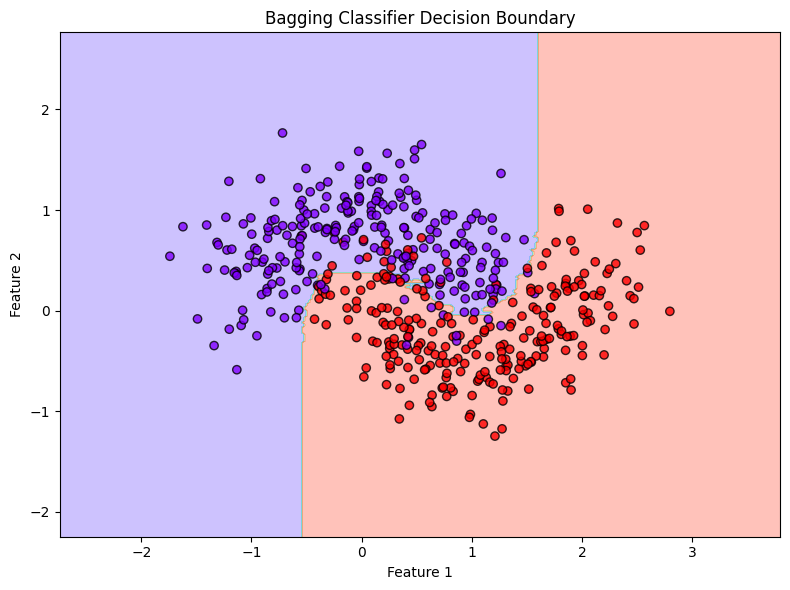

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot decision boundaries
def plot_decision_boundary(clf, X, y, ax, title):
    x1s = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
    x2s = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_grid = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_grid).reshape(x1.shape)

    # Plot the decision boundary
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=plt.cm.rainbow)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.rainbow, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_decision_boundary(bag_clf, X, y, ax, "Bagging Classifier Decision Boundary")
plt.tight_layout()
plt.show()

only 63% of the instances are sampled using this technique (with replacement) so the other 37% are not sampled and called out-of-bag (OOB) instances (its not the same 37% for all predictors)

we can use the OOB for evaluation without the need for separate validation set.

In [17]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [19]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [20]:
bag_clf.oob_decision_function_[:3] # probas for first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

^ 32% probability belonging to negtive class, ~67% to the negative

BaggingClassifier supports sampling features as well using max_features and bootstrap_features

each predictor will be trained on random subset of input features

sampling both training and features is called random patches method.

Sampling features results in more predictor diversity, trading more bias for lower variance

### Random Forest is an ensemble of decision trees trained via bagging method introduces extra randomness when growing trees

samples sqrt(n) features where n is total number of features

instead of using BaggingClassifier and passing it a DecisionTreeClassifier, this is more convenient and optimized for decision trees

In [22]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [23]:
# equivalent:
bg_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
                           n_estimators=500, n_jobs=-1, random_state=42)

Scikit-Learn measure a feature's importance by looking how much the tree nodes that use that feature reduce impurity on average across all trees in forest

In [24]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Random Forests are very handy to get a quick understanding of what features matter.

### Boosting any ensemble method that combines weak learners into strong learner

train predictors sequentially each correcting its predecessor

this does not scale well because sequential learning cannot be parallelized

A decision stump is a decision tree with max_depth=1, a tree composed of a single decision node plus two leaf nodes

In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

/Users/mathias/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

### Gradient Boosting

instead of tweaking the instance weights at every iteration like AdaBoost, this method tries to fit the new predictor to the residual errors made by the previous predictor

In [27]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100) # y = 3x^2 + gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [28]:
# second DecisionTreeRegressor based on residual errors made by first
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [29]:
# third
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [30]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

In [31]:
# same ensemble as previous:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [32]:
# early stopping instead of using cross-validation with `GridSearchCV` or `RandomizedSearchCV`
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [33]:
gbrt_best.n_estimators_

92

### stochastic gradient boosting
hyperparameter: subsample=0.25 each tree is trained on 25% of the training
instances, selected randomly trades a higher bias for a lower variance, speeds up training considerably.

### Histogram-based gradient boosting uses binning the input features and replacing them with integers

HGB classes support both categorical features and missing values
- subsampling not supported
- n_estimators renamed to max_iter
- early stopping is automatically activated if instances are greater than 10,000
- can tweak max_leaf_nodes, min_samples_leaf, max_depth

categorical features must be represented as integers ranging 0 to a number lower than max_bins, `OrdinalEncoder`

In [41]:
from pathlib import Path
import tarfile
import urllib.request
import pandas as pd

def load_housing_data():
    tarball_path = Path('./housing.tgz')
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="data")
    return pd.read_csv(Path('./data/housing/housing.csv'))

housing = load_housing_data()
housing_labels = housing["median_house_value"].copy()

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

### Stacking

instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, we can train a model to perform this aggregation

A final predictor (called a blender) takes the predictions as inputs and makes the final prediction

In [45]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5
)

stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

Ensemble methods are simple and powerful should be the first models to test for Random forests, AdaBoost and GBRT quick for quick prototyping